# Assignment 2: Experimentation & Model Training
Authors: Naomi Buell and Richie Rivera

*Assignment*

*This assignment consists of conducting at least two (2) experiments for different algorithms: Decision Trees, Random Forest and Adaboost. That is, at least six (6) experiments in total (3 algorithms x 2 experiments each). For each experiment you will define what you are trying to achieve (before each run), conduct the experiment, and at the end you will review how your experiment went. These experiments will allow you to compare algorithms and choose the optimal model.*

*Using the dataset and EDA from the previous assignment, perform the following:*

1. *Algorithm Selection:*
*You will perform experiments using the following algorithms:*
- *Decision Trees*
- *Random Forest*
- *Adaboost*

2. *Experiment:*
*For each of the algorithms (above), perform at least two (2) experiments. In a typical experiment you should:*
- *Define the objective of the experiment (hypothesis)*
- *Decide what will change, and what will stay the same*
- *Select the evaluation metric (what you want to measure)*
- *Perform the experiment*
- *Document the experiment so you compare results (track progress)*

3. *Variations:*
*There are many things you can vary between experiments, here are some examples:*

- *Data sampling  (feature selection)*
- *Data augmentation e.g., regularization, normalization, scaling*
- *Hyperparameter optimization (you decide, random search, grid search, etc.)*
- *Decision Tree breadth & depth (this is an example of a hyperparameter)*
- *Evaluation metrics e.g., Accuracy, precision, recall, F1-score, AUC-ROC*
- *Cross-validation strategy e.g., holdout, k-fold, leave-one-out*
- *Number of trees (for ensemble models)*
- *Train-test split: Using different data splits to assess model generalization ability*

## EDA Recap

### Load Libraries and Dataset

First, we import libraries and load the dataset.

In [3]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import zipfile
import io
import requests
from imblearn.under_sampling import RandomUnderSampler

We use `bank-additional-full.csv` with all examples, ordered by date (from May 2008 to November 2010). The data is enriched from the "Bank Marketing" UCI dataset by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb. This dataset is almost identical to the original, but it was found that the addition of the five new social and economic attributes (made available here) lead to substantial improvement in the prediction of a success, even when the duration of the call is not included.

We load the data and display the first few rows to understand its structure.

In [4]:
# Download the zip file from the internet
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
response = requests.get(url)

# Extract bank-additional.zip from the downloaded zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('bank-additional.zip') as additional_zip_file:
        with zipfile.ZipFile(additional_zip_file) as additional_zip:
            # Extract bank-additional-full.csv from bank-additional.zip
            with additional_zip.open('bank-additional/bank-additional-full.csv') as csvfile:
                df = pd.read_csv(csvfile, sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
print("DataFrame shape:", df.shape)

DataFrame shape: (41188, 21)


However, there are some observations set as "unknown" in several categorical columns. Additionally, the `pdays` column has a value of 999 which means the client was not previously contacted. We will treat these as missing values.

In [6]:
# Check for categorical variables that are "unknown" and replace 'unknown' with np.nan in all object (categorical) columns
df_nas = df.copy()
df_nas = df_nas.replace('unknown', np.nan)
df_nas = df_nas.replace(999, np.nan)  # Replace 999 in 'pdays' with np.nan

# Check for categorical variables that are now NA
na_counts = df_nas.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
na_perc = (na_counts / len(df_nas)) * 100
print("Columns with NA values and their % missing:")
print(na_perc.round(2))

Columns with NA values and their % missing:
pdays        96.32
default      20.87
education     4.20
housing       2.40
loan          2.40
job           0.80
marital       0.19
duration      0.00
dtype: float64


`pdays` is now 96% missing in cases where the client has not been previously contacted. `default` (whether or not the client has credit in default) has significant missingness. `education` (education level), `housing` (whether the client has a housing loan), `loan` (whether the client has a personal loan), `job` (type of job), and `marital` (marital status) have some minor missingness. We will address this missingness in the Pre-processing section.



### Data cleaning

We drop `default`, whether the client has credit in default, since it is 21% missing and there is little risk of losing valuable information that our classifier needs to discriminate between classes (most clients with known data are not in default. 79% no, <1% yes, 20% unknown). We also drop `pdays` (number of days that passed by after the client was last contacted from a previous campaign) since it is 96% missing and was determined to be not useful for prediction according to the IV. For the other columns with minor missingness (`education`, `housing`, `loan`, `job`, and `marital`), we will drop rows with missing data. Since the missingness is low, we will not lose much information by dropping these rows. We also drop the `duration` column, the last contact duration in seconds, because this attribute highly affects the output target (e.g., if duration=0 then y="no"). Per the bank data notes, this input should be discarded for our predictive model.

In [7]:
# Save a new dataframe for preprocessing
df_dropped = df_nas.copy()

# Remove `default` and `pdays` columns due to high missingness. Drop duration per data notes.
df_dropped = df_dropped.drop(columns=['default', 'pdays', 'duration'])

# Drop rows with missing values in other columns
df_dropped = df_dropped.dropna()

# Display ns before and after dropping missing values
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_dropped.shape}")

Original dataset shape: (41188, 21)
Cleaned dataset shape: (38245, 18)


We still have sufficient data to run a logistic regression model with, even after removing rows with missing values. 

### Feature Engineering

We map ordinal categorical variables to numeric values. In this case, we map the education levels to estimated number of years of schooling.

In [8]:
df_fe = df_dropped.copy()

# Map education levels to numeric values
education_mapping = {
    'illiterate': 0,                # 0 years
    'basic.4y': 4,                  # 4 years
    'basic.6y': 6,                  # 6 years
    'basic.9y': 9,                  # 9 years
    'high.school': 12,              # 12 years (typical for high school)
    'professional.course': 14,      # 14 years (post-secondary/professional)
    'university.degree': 16         # 16 years (bachelor's degree)
}
df_fe['education'] = df_fe['education'].map(education_mapping)

### Data Transformation

Because logistic regression requires categorical variables to be encoded numerically (the algorithm works with numbers, not labels), we use one-hot encoding for nominal categorical variables.

In [9]:
# One-hot encode nominal categorical variables
df_dummies = df_fe.copy()
df_dummies = pd.get_dummies(df_dummies, columns=['job', 'marital', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'], drop_first=True)
df_dummies = df_dummies.rename(columns={'y_yes': 'y'})

We also standardardize numerical columns since the majority of machine learning and optimization algorithms behave much better if features are on the same scale. We are using `RobustScaler()` to reduce the influence of outliers.

In [10]:
# Identify numerical columns
num_cols = df_dummies.select_dtypes(include=[np.number]).columns
df_standardized = df_dummies.copy()
scaler = RobustScaler()

# Fit and transform the numerical columns
df_standardized[num_cols] = scaler.fit_transform(df_standardized[num_cols])

df_standardized.head()

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,1.200000,-1.142857,-0.5,0.0,0.0,0.598477,0.857143,0.0,0.0,False,...,False,False,False,True,False,False,False,True,False,False
1,1.266667,0.000000,-0.5,0.0,0.0,0.598477,0.857143,0.0,0.0,False,...,False,False,False,True,False,False,False,True,False,False
2,-0.066667,0.000000,-0.5,0.0,0.0,0.598477,0.857143,0.0,0.0,False,...,False,False,False,True,False,False,False,True,False,False
3,0.133333,-0.857143,-0.5,0.0,0.0,0.598477,0.857143,0.0,0.0,False,...,False,False,False,True,False,False,False,True,False,False
4,1.200000,0.000000,-0.5,0.0,0.0,0.598477,0.857143,0.0,0.0,False,...,False,False,False,True,False,False,False,True,False,False


### Dimensionality Reduction

`emp.var.rate`, `euribor3m`, and `nr.employed` are all highly correlated with eachother (r = 0.91 to 0.97). To this end, we perform PCA (Principal Component Analysis) to reduce the feature space and remove some predictors. PCA is an unsupervised technique that reduces dimensionality by maximizing variance, independent of the target variable. Via PCA, we create principal components that represent linear combinations of the features.

In [11]:
# Separate features and target
X = df_standardized.drop(columns=['y'])
y = df_standardized['y']

In [12]:
# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [13]:
# initializing the PCA transformer and
# logistic regression estimator:
pca = PCA(n_components=2)

lr = LogisticRegression(random_state=1, solver='lbfgs')

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train) # standardized training data
X_test_pca = pca.transform(X_test) # standardized test data

# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)

LogisticRegression(random_state=1)

We assess the contributions of the original features to the principal components.

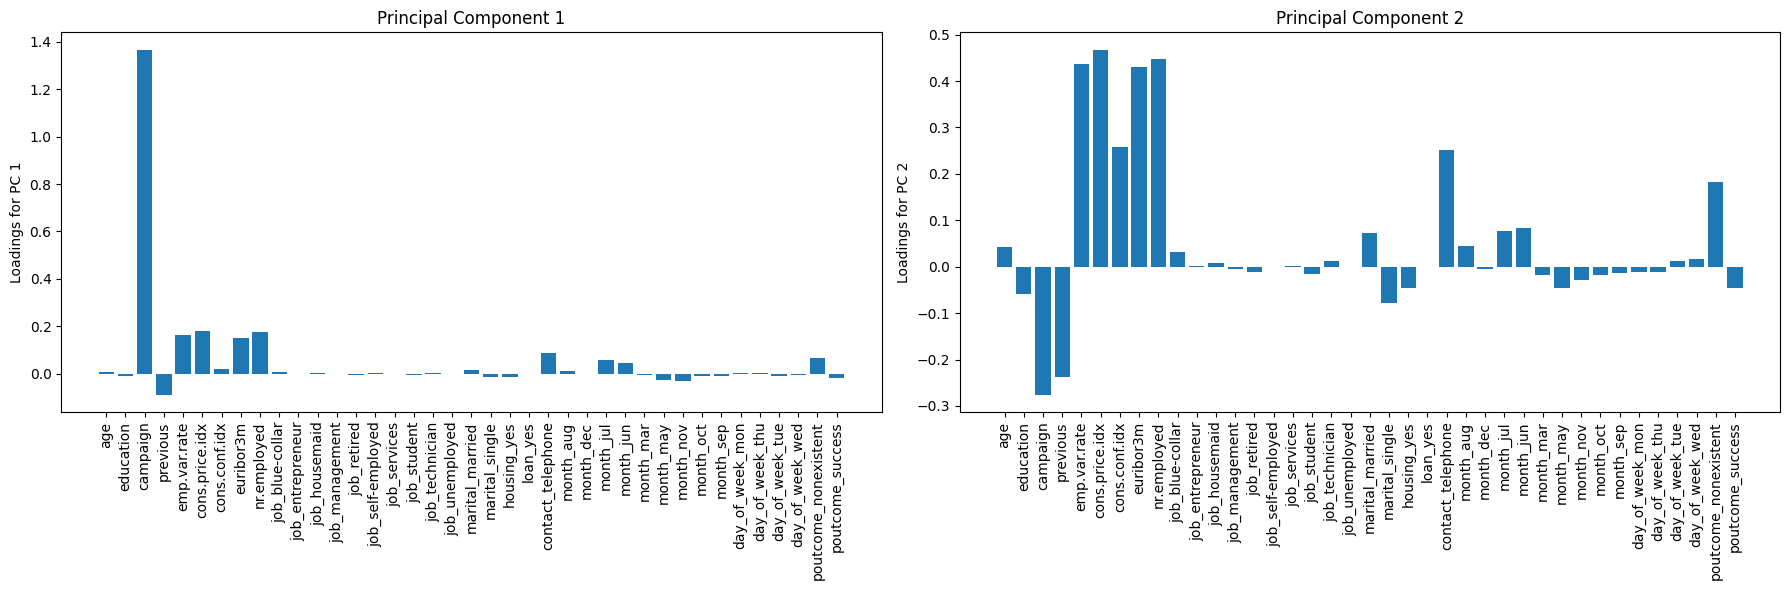

Explained variance by PC1: 25.41%
Explained variance by PC2: 14.30%
Total explained variance (PC1 + PC2): 39.71%

Top 5 features contributing to PC1:
campaign          1.366857
cons.price.idx    0.180567
nr.employed       0.174649
emp.var.rate      0.164290
euribor3m         0.152474
dtype: float64

Top 5 features contributing to PC2:
cons.price.idx    0.467802
nr.employed       0.448220
emp.var.rate      0.436115
euribor3m         0.430740
campaign          0.275466
dtype: float64


In [14]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# PC1 loadings
axes[0].bar(range(sklearn_loadings.shape[0]), sklearn_loadings[:, 0], align='center')
axes[0].set_ylabel('Loadings for PC 1')
axes[0].set_xticks(range(sklearn_loadings.shape[0]))
axes[0].set_xticklabels(X.columns, rotation=90)
axes[0].set_title('Principal Component 1')

# PC2 loadings
axes[1].bar(range(sklearn_loadings.shape[0]), sklearn_loadings[:, 1], align='center')
axes[1].set_ylabel('Loadings for PC 2')
axes[1].set_xticks(range(sklearn_loadings.shape[0]))
axes[1].set_xticklabels(X.columns, rotation=90)
axes[1].set_title('Principal Component 2')

plt.tight_layout()
plt.show()

# Summarize PCA results
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance (PC1 + PC2): {explained_variance[:3].sum():.2%}")

# Show top contributing features for each principal component
loadings = pd.Series(np.abs(sklearn_loadings[:, 0]), index=X.columns)
print("\nTop 5 features contributing to PC1:")
print(loadings.sort_values(ascending=False).head(5))

loadings2 = pd.Series(np.abs(sklearn_loadings[:, 1]), index=X.columns)
print("\nTop 5 features contributing to PC2:")
print(loadings2.sort_values(ascending=False).head(5))


In the figures above, we can see that `campaign` has the strongest positive loading on the first principal component (1.36), and is largely unaffected by other variables. This suggests that PC1 is largely influenced by the number of contacts performed during this campaign and for this client. For the second principal component, social and economic features/attributes had high loadings, with `emp.var.rate`, `cons.price.idx`, `euribor3m`, and `nr.employed` having high loadings (0.43-0.45). `campaign` (-0.28) had a weaker negative loading on PC2. 

### Data Imbalance and Sampling
As noted from the previous distribution section, 36,548 of 41,188 (about 88.7%) of outcomes were a `no`. In order to account for this data imbalance, we have a few options, each with their own advantages and disadvantages:
| Method | Pros | Cons |
| :--- | :--- | :--- |
| **Oversampling Minority Class** | - No data loss. <br> - Simple to implement. | - Can lead to overfitting.  |
| **Undersampling Majority Class** | - Faster training. <br> - Can reduce noise. | - **Discards valuable data**. |
| **Assign larger penalty to the minority class** | - Doesn't alter original data. <br> - Simple to implement. <br> - Directly targets misclassification. | - Model is still trained on imbalanced data. <br> - Requires hyperparameter tuning. |
| **Generating synthetic samples** | - No information loss. <br> - Prevents overfitting better. | - Can introduce noise. |


Given our specific dataset, it's not recommended to oversample the minority class to match the majority class or generating synthetic samples as we'll be introducing too much duplication and would likely overfit the model or introduce too much noise.

Since assigning a larger penalty to the minority class is done during model development, we will sample our dataset to undersample the majority class in the dataframe below:

In [15]:
# Creating our random sampler
rus = RandomUnderSampler(random_state=2111994)

# Defining an x and y for our data
df_sampled = rus.fit_resample(df_standardized.drop('y', axis=1),df_standardized['y'])
df_undersampled = {
    'x' : df_sampled[0],
    'y' : df_sampled[1]
}

# Show the balance of the data after the resampling
df_undersampled['y'].value_counts()

y
False    4258
True     4258
Name: count, dtype: int64

With our dataset undersampled, we can see that we have rebalanced our data to align perfectly.

## Step 1: Algorithm Selection

## Step 2: Experiment

## Step 3: Variations